In [25]:
import os, gc, sys
import pygrib
import regionmask
import cartopy
import cartopy.crs as ccrs
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import multiprocessing as mp
import matplotlib.pyplot as plt 
import matplotlib as mpl

from glob import glob
from numpy import trapz
from scipy.integrate import simps
from functools import partial
from matplotlib import gridspec
from datetime import datetime, timedelta
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import colors

import warnings
warnings.filterwarnings('ignore')

os.environ['OMP_NUM_THREADS'] = '1'

In [26]:
# CONFIG # # CONFIG # # CONFIG # # CONFIG # # CONFIG # 
cwa = 'SEW'# 'SEW'#sys.argv[1]
fhr_start, fhr_end, fhr_step = 24, 180, 6#108, 6

# start_date = datetime(2020, 5, 18, 0)
# end_date = datetime(2020, 10, 1, 0)

start_date = datetime(2020, 10, 1, 0)
end_date = datetime(2020, 12, 1, 0)

interval = 24

produce_thresholds = [0.01, 0.1, 0.25, 0.50, 1.0]
bint, bins_custom = 10, None

cwa_bounds = {
    'WESTUS':[30, 50, -130, -100],
    'SEW':[46.0, 49.0, -125.0, -120.5],
    'SLC':[37.0, 42.0, -114.0, -110],
    'MSO':[44.25, 49.0, -116.75, -112.25],
    'MTR':[35.75, 38.75, -123.5, -120.25],}

n_events = 3
cx = 8 if cwa == 'WESTUS' else 4
cy = cx
# CONFIG # # CONFIG # # CONFIG # # CONFIG # # CONFIG # 

In [27]:
nbm_dir = '/scratch/general/lustre/u1070830/nbm/'
urma_dir = '/scratch/general/lustre/u1070830/urma/'
tmp_dir = '/scratch/general/lustre/u1070830/tmp/'
fig_dir = '/uufs/chpc.utah.edu/common/home/steenburgh-group10/mewessler/nbm/'
os.makedirs(tmp_dir, exist_ok=True)

In [28]:
def custom_cbar(_bins):
    
    base_colors = ['#a6611a','#dfc27d','white','#80cdc1','#018571'][::-1]
    lev = np.unique([0, _bins[0]-10, _bins[0], _bins[1]+10, _bins[1], 100])
    lev = lev[((lev >= 0) & (lev <= 100))]

    if _bins[0] == 0:
        cmap = colors.ListedColormap(base_colors[-3:])
        cbar_label = '\n                   Observed Relative Frequency [1 Bin Too Dry >] [Too Dry >]'
    
    elif _bins[1] == 100:
        cmap = colors.ListedColormap(base_colors[:3])
        cbar_label = '\n[< Too Wet] [< 1 Bin Too Wet] Observed Relative Frequency                   '
    
    else:
        cbar_label = ('\n[< Too Wet]  [< 1 Bin Too Wet]                [1 Bin Too Dry >]  [Too Dry >]' + 
                     '\n\nObserved Relative Frequency')
        
        if _bins[0] == 10:
            cmap = colors.ListedColormap(base_colors[1:5])
        elif _bins[1] == 90:
            cmap = colors.ListedColormap(base_colors[-5:-1])
        else:
            cmap = colors.ListedColormap(base_colors)
    
    cbar_label = '\nObserved Relative Frequency\nGray where n observed events < 5'
    
    return [lev, cmap, cbar_label]

def resize_colobar(event):
    # Tell matplotlib to re-draw everything, so that we can get
    # the correct location from get_position.
    plt.draw()

    posn = ax.get_position()
    colorbar_ax.set_position([posn.x0 + posn.width + 0.01, posn.y0,
                             0.04, axpos.height])

In [29]:
def extract_pbin_stats(_fhr, _urma):

    nbm_file = glob(nbm_dir + 'extract/nbm_probx_fhr%03d.nc'%_fhr)[0]
    
    # Subset the threshold value
    nbm = xr.open_dataset(nbm_file)['probx'].sel(
    y=slice(idx[0].min(), idx[0].max()),
    x=slice(idx[1].min(), idx[1].max()))

    # Subset the times
    nbm_time = nbm.valid
    urma_time = _urma.valid
    time_match = nbm_time[np.in1d(nbm_time, urma_time)].values
    time_match = np.array([t for t in time_match if pd.to_datetime(t) >= start_date])
    time_match = np.array([t for t in time_match if pd.to_datetime(t) <= end_date])
    date0 = pd.to_datetime(time_match[0]).strftime('%Y/%m/%d %H UTC')
    date1 = pd.to_datetime(time_match[-1]).strftime('%Y/%m/%d %H UTC')

    _nbm = nbm.sel(valid=time_match)
    _urma = _urma.sel(valid=time_match)
    nbm_mask, _nbm = xr.broadcast(mask, _nbm)
    urma_mask, _urma = xr.broadcast(mask, _urma)

    _nbm_masked = xr.where(nbm_mask, _nbm, np.nan)
    _urma_masked = xr.where(urma_mask, _urma, np.nan)
    
    data = []
    
    for thresh in produce_thresholds:
        
        print('Processing f%03d %.2f"'%(_fhr, thresh))

        _nbm_masked_select = _nbm_masked.sel(threshold=thresh)

        for bins in zip(np.arange(0, 101-bint, bint), np.arange(0+bint, 101, bint)):

            b0, b1 = bins
            center = b1-bint
            levels = np.unique([0, b0, b1, 100])

            N = xr.where(
                    (_nbm_masked_select > b0) & 
                    (_nbm_masked_select <= b1), 
                1, 0).sum(dim='valid')

            n = xr.where(
                (_nbm_masked_select > b0) & 
                (_nbm_masked_select <= b1) & 
                (_urma_masked > thresh), 
                1, 0).sum(dim='valid')
                        
            # hit, yesFx/yesOb
            a = xr.where(
                (_nbm_masked_select >= center) &
                (_urma_masked > thresh),
                1, 0).sum(dim='valid')
            
            # false alarm, yesFx/noOb
            b = xr.where(
                (_nbm_masked_select >= center) &
                ((_urma_masked <= thresh)),#|np.isnan(_urma_masked)),
                1, 0).sum(dim='valid')
            
            # miss, noFx/yesOb
            c = xr.where(
                (_nbm_masked_select <= center) &
                (_urma_masked > thresh),
                1, 0).sum(dim='valid')
            
            # correct negative, noFx/noOb
            d = xr.where(
                (_nbm_masked_select <= center) &
                (_urma_masked <= thresh),
                1, 0).sum(dim='valid')
            
            # # # # # #
            
            obs_rel_freq = xr.where(n > 5, n/N, np.nan)*100
            
            data.append([thresh, _fhr, bins, n, N, [a, b, c, d]])
    
    return data

In [30]:
extract_dir = nbm_dir + 'extract/'
extract_flist = sorted(glob(extract_dir + '*'))

if not os.path.isfile(urma_dir + 'agg/urma_agg.nc'):
    pass 
    #print('URMA aggregate not found')

else:
    #print('Getting URMA aggregate from file')
    urma = xr.open_dataset(urma_dir + 'agg/urma_agg.nc')['apcp24h_mm']

urma = urma/25.4
urma = urma.rename('apcp24h_in')
lons, lats = urma.lon, urma.lat

# Masking with regionmask and zones shapefile

In [31]:
geodir = '../forecast-zones/'
zones_shapefile = glob(geodir + '*.shp')[0]

# Read the shapefile
zones = gpd.read_file(zones_shapefile)

# Prune to Western Region using TZ
zones = zones.set_index('TIME_ZONE').loc[['M', 'Mm', 'm', 'MP', 'P']].reset_index()
cwas = zones.dissolve(by='CWA').reset_index()[['CWA', 'geometry']]
_cwas = cwas.copy()

if cwa == 'WESTUS':
    _cwas['CWA'] = 'WESTUS'
    _cwas = _cwas.dissolve(by='CWA').reset_index()
    bounds = _cwas.total_bounds
else:
    bounds = _cwas[_cwas['CWA'] == cwa].bounds.values[0]
    
print(bounds)
    
lons, lats = urma.lon, urma.lat
mask = regionmask.mask_3D_geopandas(_cwas, lons, lats).rename({'region':'cwa'})
mask['cwa'] = _cwas.iloc[mask.cwa]['CWA'].values.astype(str)
mask = mask.sel(cwa=cwa)
mask

[-124.762578     46.38421249 -120.65499878   49.00241089]


<xarray.DataArray (y: 1051, x: 1132)>
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Coordinates:
  * y        (y) int64 0 1 2 3 4 5 6 7 ... 1044 1045 1046 1047 1048 1049 1050
  * x        (x) int64 0 1 2 3 4 5 6 7 ... 1125 1126 1127 1128 1129 1130 1131
    lat      (y, x) float32 26.477743 26.483274 26.4888 ... 52.766827 52.767593
    lon      (y, x) float32 -128.18382 -128.15907 ... -100.213776 -100.18081
    cwa      <U3 'SEW'

In [32]:
idx = np.where(
    (urma.lat >= bounds[1]) & (urma.lat <= bounds[3]) &
    (urma.lon >= bounds[0]) & (urma.lon <= bounds[2]))

mask = mask.isel(y=slice(idx[0].min(), idx[0].max()), x=slice(idx[1].min(), idx[1].max()))
urma = urma.isel(y=slice(idx[0].min(), idx[0].max()), x=slice(idx[1].min(), idx[1].max()))
urma = urma.transpose('valid', 'y', 'x')

# Bulk of the data processing

In [33]:
fhrs = np.arange(fhr_start, fhr_end+1, fhr_step)
extract_pbin_stats_mp = partial(extract_pbin_stats, _urma=urma)
max_pool = 16 if cwa != 'WESTUS' else 4
pool_count = len(fhrs) if len(fhrs) < max_pool else max_pool

with mp.get_context('fork').Pool(pool_count) as p:
    returns = p.map(extract_pbin_stats_mp, fhrs)
    p.close()
    p.join()
    
returns = np.array(returns, dtype=object).reshape(-1, 6)

data = {fhr:{threshold:[] for threshold in produce_thresholds} for fhr in fhrs}

for item in returns:
    threshold, fhr = item[:2]
    data[fhr][threshold].append(item[2:])

Processing f024 0.01"
Processing f030 0.01"
Processing f036 0.01"
Processing f042 0.01"
Processing f048 0.01"
Processing f054 0.01"
Processing f060 0.01"
Processing f066 0.01"
Processing f072 0.01"
Processing f024 0.10"
Processing f030 0.10"
Processing f036 0.10"
Processing f042 0.10"
Processing f054 0.10"
Processing f048 0.10"
Processing f060 0.10"
Processing f066 0.10"
Processing f078 0.01"
Processing f084 0.01"
Processing f072 0.10"
Processing f090 0.01"
Processing f096 0.01"
Processing f024 0.25"
Processing f102 0.01"
Processing f030 0.25"
Processing f108 0.01"
Processing f096 0.10"
Processing f036 0.25"
Processing f102 0.10"
Processing f042 0.25"
Processing f108 0.10"
Processing f054 0.25"
Processing f096 0.25"
Processing f048 0.25"
Processing f060 0.25"
Processing f102 0.25"
Processing f066 0.25"
Processing f078 0.10"
Processing f108 0.25"
Processing f084 0.10"
Processing f072 0.25"
Processing f096 0.50"
Processing f090 0.10"
Processing f102 0.50"
Processing f024 0.50"
Processing

# Combination Map Plots

In [ ]:
fhr = 24

for thresh in produce_thresholds:

    # Make the plot
    fig = plt.figure(figsize=(30, 28), facecolor='w')
    axs = [plt.subplot(4, 4, i+1, projection=ccrs.PlateCarree()) for i in range(10)]

    relplot = []
    for ax, bin_data in zip(axs, data[fhr][thresh]):
        
        bins, n, N = bin_data[:-1]
        n = n.coarsen(x=cx, y=cy, boundary='trim').sum()
        N = N.coarsen(x=cx, y=cy, boundary='trim').sum()
        obs_rel_freq = (n/N)*100
        
        levels, cmap, cbar_label = custom_cbar(bins)

        center = np.mean(bins)/100
        agg_obs_rel_freq = n.sum()/N.sum()
        relplot.append([center, agg_obs_rel_freq, n.sum(), N.sum()])

        if cwa != 'WESTUS':
            zones.geometry.boundary.plot(color=None, linestyle='--', edgecolor='black', linewidth=0.75, ax=ax)

        cwas.geometry.boundary.plot(color=None, edgecolor='black', linewidth=1.5, ax=ax)
        ax.add_feature(cartopy.feature.OCEAN, zorder=100, color='w', edgecolor=None)
        ax.coastlines(linewidth=2, zorder=101)

        cbd = ax.contourf(obs_rel_freq.lon, obs_rel_freq.lat, xr.where(n >= n_events, obs_rel_freq, np.nan),
                         levels=levels, cmap=cmap)
        
        try:
            nan_shade = xr.where((np.isnan(obs_rel_freq) | (n < n_events)) & mask, -1, np.nan)
            ax.contourf(obs_rel_freq.lon, obs_rel_freq.lat, nan_shade, cmap='gray', alpha=0.65)
        except:
            pass
        
        if cwa == 'SLC':
            # Square out the boundaries
            crg = ccrs.PlateCarree()
            LL = crg.transform_point(bounds[0], bounds[1], ccrs.Geodetic())
            UR = crg.transform_point(bounds[2], bounds[3], ccrs.Geodetic())
            EW = UR[0] - LL[0]
            SN = UR[1] - LL[1]
            side = max(EW, SN)
            mid_x, mid_y = LL[0]+EW/2.0, LL[1]+SN/2.0
            extent = [mid_x-side/1.25, mid_x+side/1.25, mid_y-side/1.75, mid_y+side/1.75]
            ax.set_extent(extent, crs=crg)
        
        ax.set_title('Forecast Probability Bin: %d%% - %d%%'%(bins[0], bins[1]), fontsize=14)

    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    cbar_ax = fig.add_axes([.92, .58, .015, .30])
    levels, cmap, cbar_label = custom_cbar((25, 75))
    norm = mpl.colors.BoundaryNorm(levels, cmap.N)
    cbar = mpl.colorbar.ColorbarBase(cbar_ax, cmap=cmap, norm=norm, ticks=[], boundaries=levels)
    cbar.set_label(label=cbar_label, fontsize=18)

    date0, date1 = start_date.strftime('%Y-%m-%d'), end_date.strftime('%Y-%m-%d')
    plt.suptitle('CWA: %s %s - %s\nInterval: %02dh, Threshold: %.02f"\nFHR: %03d\n'%(cwa, date0, date1, interval, thresh, fhr), fontsize=16)
    fig.subplots_adjust(top=0.94)

    # Reliability Plot
    relplot = np.array(relplot)
    ax = plt.subplot(4, 4, 12)
    ax.plot(relplot[:, 0], relplot[:, 1], linewidth=3, color='r',
            marker='+', markersize=15, label='ALL')

    perfect = np.arange(0, 1.1, .1)
    
    _urma, _mask = xr.broadcast(urma, mask)
    _urma = xr.where(_mask, _urma, np.nan)
    climo = xr.where((_urma > thresh), 1, 0).sum().values/_urma.size    
    
    skill = perfect - ((perfect - climo)/2)

    ax.plot(perfect, perfect, 
            color='k')

    ax.axhline(climo, 
            color='k', linestyle='--')

    ax.plot(perfect, skill, 
            color='k', linestyle='--')

    fillperf = np.arange(climo, 1, .001)
    ax.fill_between(fillperf, fillperf - (fillperf - climo)/2, 1,
            color='gray', alpha=0.35)

    fillperf = np.arange(0, climo, .001)
    ax.fill_between(fillperf, 0, fillperf - (fillperf - climo)/2,
            color='gray', alpha=0.35)

    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])

    ax.set_xticks(perfect)
    ax.set_yticks(perfect)

    ax.set_xlabel('Forecast Probability')
    ax.set_ylabel('Observed Relative Frequency')
    ax.grid(zorder=1)

    ax.legend(loc='upper left')

    # # # # # # # # # # # # # # # # # # # # # # # #
    ax1 = plt.axes([.795, .345, .1, .028], facecolor='w')

    ax1.bar(relplot[:, 0], relplot[:, 3], color='k', width=0.095, zorder=10)
    ax1.bar(relplot[:, 0], relplot[:, 2], color='r', alpha=0.25, width=0.095, zorder=11)

    ax1.set_xlim([0, 1])

    ax1.set_yscale('log')
    ax1.set_yticks([1e2, 1e4, 1e6, 1e8])
    ax1.set_yticklabels([])

    ax1.set_xlabel('Forecast Probability')
    #ax1.set_ylabel('# Forecasts')
    ax1.grid(zorder=-1)
    
    cbar.ax.text(27, 83, 'Too Dry >', rotation=90, fontsize=18)
    cbar.ax.text(27, 64, '+1 Bin >', rotation=90, fontsize=18)
    cbar.ax.text(27, 43, 'Within Bin', rotation=90, fontsize=18)
    cbar.ax.text(27, 24, '< -1 Bin', rotation=90, fontsize=18)
    cbar.ax.text(27, 3, '< Too Wet', rotation=90, fontsize=18)

    plt.show()

# Full-size map plots

In [ ]:
fhr = 24

for thresh in produce_thresholds:
    
    for bin_data in data[fhr][thresh]:
        
        fig = plt.figure(figsize=(12, 12), facecolor='w')
        ax = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())
        
        bins, n, N = bin_data[:-1]
        n = n.coarsen(x=cx, y=cy, boundary='trim').sum()
        N = N.coarsen(x=cx, y=cy, boundary='trim').sum()
        obs_rel_freq = (n/N)*100
        
        levels, cmap, cbar_label = custom_cbar(bins)

        if cwa != 'WESTUS':
            zones.geometry.boundary.plot(color=None, linestyle='--', edgecolor='black', linewidth=0.75, ax=ax)

        cwas.geometry.boundary.plot(color=None, edgecolor='black', linewidth=1.5, ax=ax)
        ax.add_feature(cartopy.feature.OCEAN, zorder=100, color='w', edgecolor=None)
        ax.coastlines(linewidth=2, zorder=101)

        cbd = ax.contourf(obs_rel_freq.lon, obs_rel_freq.lat, xr.where(n >= n_events, obs_rel_freq, np.nan),
                         levels=levels, cmap=cmap)
        
        try:
            nan_shade = xr.where((np.isnan(obs_rel_freq) | (n < n_events)) & mask, -1, np.nan)
            ax.contourf(obs_rel_freq.lon, obs_rel_freq.lat, nan_shade, cmap='gray', alpha=0.65)
        except:
            pass
        
        if cwa == 'SLC':
            # Square out the boundaries
            crg = ccrs.PlateCarree()
            LL = crg.transform_point(bounds[0], bounds[1], ccrs.Geodetic())
            UR = crg.transform_point(bounds[2], bounds[3], ccrs.Geodetic())
            EW = UR[0] - LL[0]
            SN = UR[1] - LL[1]
            side = max(EW, SN)
            mid_x, mid_y = LL[0]+EW/2.0, LL[1]+SN/2.0
            extent = [mid_x-side/1.25, mid_x+side/1.25, mid_y-side/1.75, mid_y+side/1.75]
            ax.set_extent(extent, crs=crg)
        
        ax.set_title('Forecast Probability Bin: %d%% - %d%%'%(bins[0], bins[1]), fontsize=14)

        plt.subplots_adjust(wspace=0.05, hspace=0.05)
        cbar_ax = fig.add_axes([.92, .20, .03, .65])
        levels, cmap, cbar_label = custom_cbar((25, 75))
        norm = mpl.colors.BoundaryNorm(levels, cmap.N)
        cbar = mpl.colorbar.ColorbarBase(cbar_ax, cmap=cmap, norm=norm, ticks=[], boundaries=levels)
        cbar.set_label(label=cbar_label, fontsize=18)

        date0, date1 = start_date.strftime('%Y-%m-%d'), end_date.strftime('%Y-%m-%d')
        plt.suptitle('CWA: %s %s - %s\nInterval: %02dh, Threshold: %.02f"\nFHR: %03d\n'%(cwa, date0, date1, interval, thresh, fhr), fontsize=16)
        fig.subplots_adjust(top=0.875)

        cbar.ax.text(27, 83, 'Too Dry >', rotation=90, fontsize=12)
        cbar.ax.text(27, 64, '+1 Bin >', rotation=90, fontsize=12)
        cbar.ax.text(27, 43, 'Within Bin', rotation=90, fontsize=12)
        cbar.ax.text(27, 24, '< -1 Bin', rotation=90, fontsize=12)
        cbar.ax.text(27, 3, '< Too Wet', rotation=90, fontsize=12)
        
        plt.show()

# Time-aggregate Reliability Diagrams

In [ ]:
for thresh in produce_thresholds:
    
    fig = plt.figure(figsize=(9, 11), facecolor='w')
    axs = gridspec.GridSpec(2, 1, height_ratios=[4, 1]) 
    ax = plt.subplot(axs[0])
    ax1 = plt.subplot(axs[1])
    
    relplot_agg = []
    for fhr in fhrs:

        relplot = []
        for bin_data in data[fhr][thresh]:
            
            bins, n, N = bin_data[:-1]
            center = np.mean(bins)/100

            n = n.sum()
            N = N.sum()
            obs_rel_freq = (n/N)
        
            relplot.append([center, obs_rel_freq, n.sum(), N.sum()])
        
        relplot = np.array(relplot)
        relplot_agg.append(relplot)
        
        ax.plot(relplot[:, 0], relplot[:, 1], linewidth=1,
                marker='+', markersize=15, label='F%03d'%fhr)
        
    relplot_agg = np.array(relplot_agg)
    
    relplot_agg = np.array(
        [relplot_agg.mean(axis=0)[:, 0], 
        relplot_agg.sum(axis=0)[:, 2]/relplot_agg.sum(axis=0)[:, 3]])


    ax.plot(relplot_agg[0], relplot_agg[1], linewidth=3, color='r',
            marker='+', markersize=15, label='ALL')

    perfect = np.arange(0, 1.1, .1)

    _urma, _mask = xr.broadcast(urma, mask)
    _urma = xr.where(_mask, _urma, np.nan)
    climo = xr.where((_urma > thresh), 1, 0).sum().values/_urma.size

    skill = perfect - ((perfect - climo)/2)

    ax.plot(perfect, perfect, 
            color='k')

    ax.axhline(climo, 
            color='k', linestyle='--')

    ax.plot(perfect, skill, 
            color='k', linestyle='--')

    fillperf = np.arange(climo, 1, .001)
    ax.fill_between(fillperf, fillperf - (fillperf - climo)/2, 1,
            color='gray', alpha=0.35)

    fillperf = np.arange(0, climo, .001)
    ax.fill_between(fillperf, 0, fillperf - (fillperf - climo)/2,
            color='gray', alpha=0.35)

    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])

    ax.set_xticks(perfect)
    ax.set_yticks(perfect)

    ax.set_xlabel('Forecast Probability')
    ax.set_ylabel('Observed Relative Frequency')
    ax.grid(zorder=1)
    
    date0, date1 = start_date.strftime('%Y-%m-%d'), end_date.strftime('%Y-%m-%d')

    ax.set_title((
        'NBM Reliability | CWA: %s\n'%cwa +
        '%s - %s\n'%(date0, date1) + 
        '%02dh Acc QPF | %3dh Lead Time\n\n'%(interval, fhr) +
        'Probability of Exceeding %.2f"\n\n'%thresh + 
        'n forecast prob > 0: %2.1e | n observed > %.2f: %2.1e'%(
            relplot[:, 2].sum(), thresh, relplot[:, 3].sum())))

    ax.legend(loc='upper left')

    # # # # # # # # # # # # # # # # # # # # # # # # 

    ax1.bar(relplot_agg[0], relplot[:, 3].sum(), color='k', width=0.095, zorder=10)
    ax1.bar(relplot_agg[0], relplot[:, 2].sum(), color='r', alpha=0.25, width=0.095, zorder=11)

    ax1.set_xticks(np.arange(0, 1.1, .1))
    ax1.set_xlim([0, 1])

    ax1.set_yscale('log')
    ax1.set_yticks([1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8, 1e9])

    ax1.set_xlabel('Forecast Probability')
    ax1.set_ylabel('# Forecasts')
    ax1.grid(zorder=-1)

    plt.show()

# Lead-time Aggregate Map Plots

In [ ]:
# fhrs = [24, 48, 60, 84]

# for thresh in produce_thresholds:
    
#     for fhr in fhrs:
    
#         for bin_data in data[fhr][thresh]:

#             bins, n, N = bin_data
#             n = n.coarsen(x=cx, y=cy, boundary='trim').sum()
#             N = N.coarsen(x=cx, y=cy, boundary='trim').sum()
#             obs_rel_freq = (n/N)*100
            
#             print(thresh, fhr, bins)

# ROC Curves

#### Begin with FAR and HR
n is hit rate
N is part of hit + miss

H = POD = hit / (hit + miss)

Note that in basic testing, increased bin width inflates AUC

In [ ]:
for thresh in produce_thresholds[:1]:
    
    for fhr in [24]:
        
        rocplot = [[1, 1, 1]]
        for bin_data in data[fhr][thresh]:

            bins = bin_data[0]
            center = np.mean(bins)/100
            
            con_table = bin_data[-1]
            a, b, c, d = [i.sum().values for i in con_table]
            
            n = a + b + c + d
            accuracy = (a + d) / n
            bias_score = (a + b) / (a + c)
            pod = a / (a + c)
            far = b / (a + b)
            pofd = b / (d + b)
            sr = a / (a + b)
            ts = csi = a / (a + c + b)
            a_rand = ((a + c)*(a + b)) / n
            ets = (a - a_rand) / (a + c + b - a_rand)
            expect_correct_rand = (1/n) * (((a + c)*(a + b)) + ((d + c)*(d + b)))
            hss = ((a + d) - expect_correct_rand) / (n - expect_correct_rand)
            
            plot_contingency = False
            if plot_contingency == True:                
                print('Accuracy (Fraction Correct): %.3f'%accuracy)
                print('Bias Score (Frequency Bias): %.3f'%bias_score)
                print('Probability of Detection (Hit Rate): %.3f'%pod)
                print('False Alarm Ratio: %.3f'%far)
                print('Probability of False Detection (False Alarm Rate): %.3f'%pofd)
                print('Success Ratio: %.3f'%sr)
                print('Threat Score (Critical Success Index): %.3f'%ts)
                print('Equitable Threat Score (Gilbert Skill Score): %.3f'%ets)
                print('Heidke skill score (Cohens k): %.3f'%hss)
                print()
                
                fig, ax = plt.subplots(facecolor='w')

                ax.text(.1, .1, 'Total', fontsize=14)
                ax.text(.7, .4, 'Total', fontsize=14)

                ax.text(.1, .3, 'Yes', fontsize=14)
                ax.text(.1, .2, 'No', fontsize=14)

                ax.text(.3, .4, 'Yes', fontsize=14)
                ax.text(.5, .4, 'No', fontsize=14)

                ax.text(.3, .3, a, fontsize=14)
                ax.text(.5, .3, b, fontsize=14)
                ax.text(.3, .2, c, fontsize=14)
                ax.text(.5, .2, d, fontsize=14)
                ax.text(.7, .3, a+b, fontsize=14)
                ax.text(.7, .2, c+d, fontsize=14)
                ax.text(.5, .1, b+d, fontsize=14)
                ax.text(.3, .1, a+c, fontsize=14)

                ax.text(.3, .325, 'a: hits', fontsize=10, weight='bold')
                ax.text(.5, .325, 'b: false\nalarms', fontsize=10, weight='bold')
                ax.text(.3, .225, 'c: misses', fontsize=10, weight='bold')
                ax.text(.5, .225, 'd: correct\nnegatives', fontsize=10, weight='bold')
                ax.text(.7, .325, 'a+b', fontsize=14, weight='bold')
                ax.text(.7, .225, 'c+d', fontsize=14, weight='bold')
                ax.text(.5, .125, 'b+d', fontsize=14, weight='bold')
                ax.text(.3, .125, 'a+c', fontsize=14, weight='bold')

                ax.text(.7, .125, 'n', fontsize=14, weight='bold')
                ax.text(.7, .1, a+b+c+d, fontsize=14)

                ax.axhline(.17, c='k')
                ax.axhline(.27, c='k')
                ax.axhline(.37, c='k')
                ax.axhline(.47, c='k')
                ax.axvline(.25, c='k')
                ax.axvline(.46, c='k')    
                ax.axvline(.65, c='k')

                ax.set_xticks([])
                ax.set_yticks([])

                ax.set_xlim(.09, .85)
                ax.set_ylim(0.05, .45)

                ax.set_title('fhr %s, threshold %s, bin >= %s'%(fhr, thresh, center))
                plt.show()
            
            rocplot.append([far, pod, center])
        
        rocplot.append([0, 0, 0])
        rocplot = np.array(rocplot)
        
        # Use trapz method to calculate AUC (> reimann for wide bins, < reimann for width 1)
        auc = trapz(rocplot[:, 1], dx=bint)/100
        
        # Use simpson's rule to calculate AUC 
        # auc = simps(rocplot[:, 1], dx=bint)/100
        
        # Use reimann sums to calculate AUC
        # auc = (sum(rocplot[:, 1])*bint)/100
        
        fig, ax = plt.subplots(figsize=(10, 10), facecolor='w')
        
        ax.plot(rocplot[:, 0], rocplot[:, 1], marker='o', markersize=7.5, color='r', linewidth=2)
        [ax.text(x*1.04, y*.97, s, fontsize=10) for x, y, s in rocplot[1:-1]]
        
        ax.plot(np.arange(0, 1.1), np.arange(0, 1.1), 'k--')
        
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        
        date0, date1 = start_date.strftime('%Y-%m-%d'), end_date.strftime('%Y-%m-%d')
        ax.set_title((
            'NBM Receiver Operating Characteristic | CWA: %s\n'%cwa +
            '%s - %s\n'%(date0, date1) + 
            '%02dh Acc QPF | %3dh Lead Time\n\n'%(interval, fhr) +
            'Probability of Exceeding %.2f"\n'%thresh))
        
        ax.set_xlabel('False Alarm Rate (POFD)')
        ax.set_ylabel('Probability of Detection (POD)')
        ax.text(.45, .42, 'No Skill', rotation=45, fontsize=14)
        ax.text(.85, .025, 'AUC: %.2f'%auc, rotation=0, fontsize=14, weight='bold')
        
        ax.grid()
        
        break

### Lead Time Aggregate ROC Curves

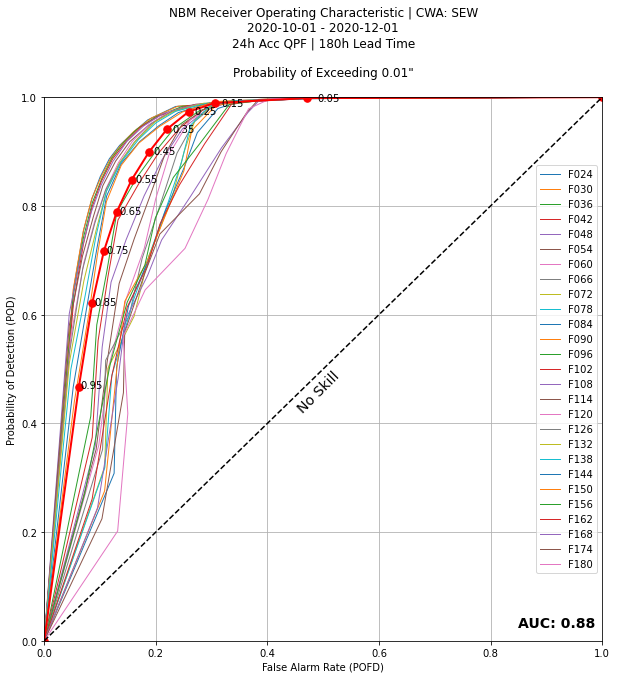

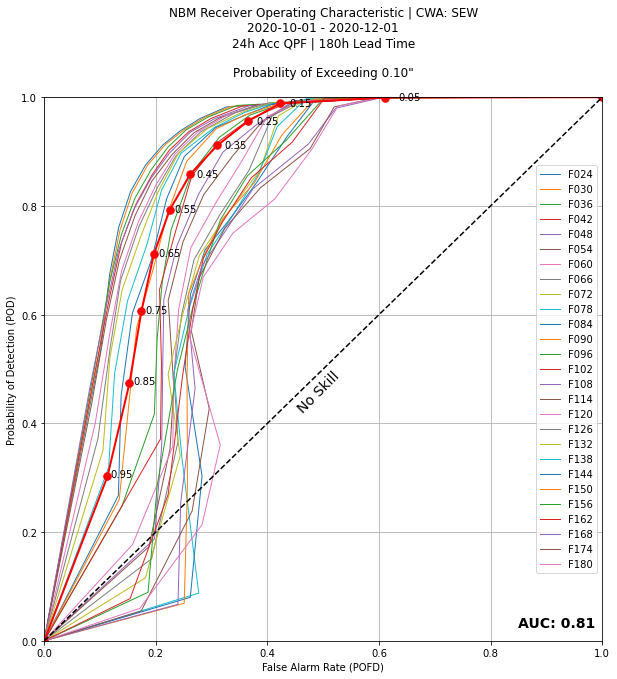

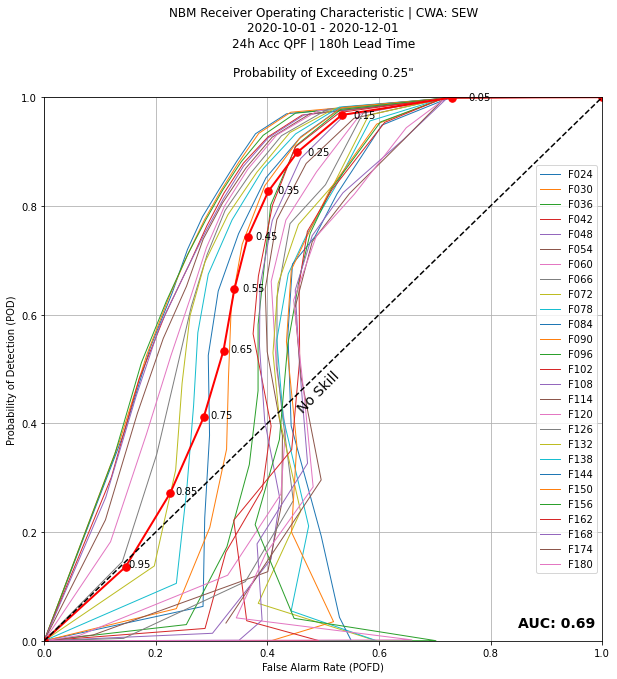

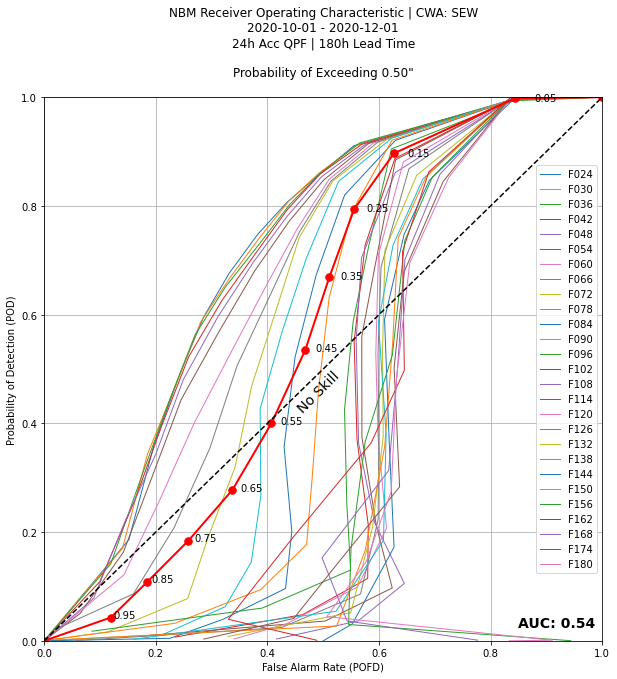

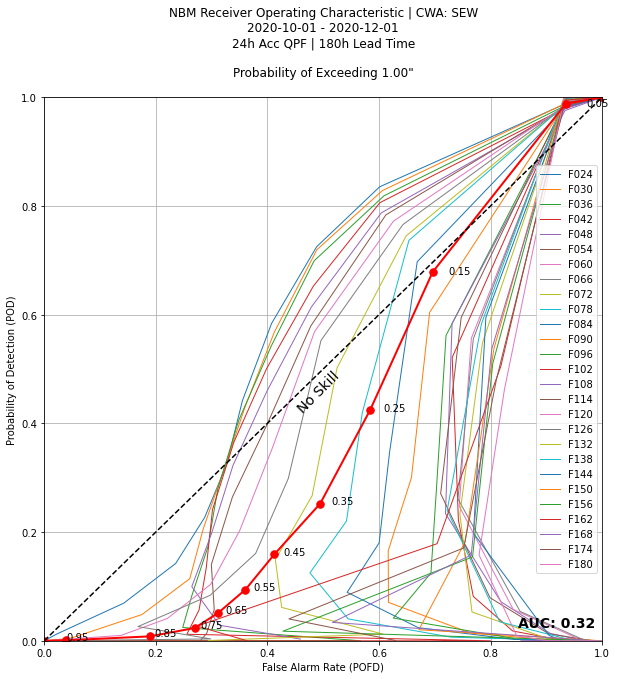

In [34]:
bin_list = [i[0] for i in data[fhrs[0]][produce_thresholds[0]]]

for thresh in produce_thresholds:
    
    rocplot_agg_data = {np.mean(bins)/100:{k:[] for k in ['a', 'b', 'c', 'd']} for bins in bin_list}    
    fig, ax = plt.subplots(figsize=(10, 10), facecolor='w')
    
    for fhr in fhrs:
        
        rocplot = [[1, 1, 1]]
        for bin_data in data[fhr][thresh]:

            bins = bin_data[0]
            center = np.mean(bins)/100
            
            con_table = bin_data[-1]
            a, b, c, d = [i.sum().values for i in con_table]
            
            pod = a / (a + c)
            far = b / (a + b)
            
            rocplot.append([far, pod, center])
            rocplot_agg_data[center]['a'].append(a)
            rocplot_agg_data[center]['b'].append(b)
            rocplot_agg_data[center]['c'].append(c)
            rocplot_agg_data[center]['d'].append(d)
        
        rocplot.append([0, 0, 0])
        rocplot = np.array(rocplot)
        
        ax.plot(rocplot[:, 0], rocplot[:, 1], linewidth=1, label='F%03d'%fhr)
     
    rocplot_agg = [[1, 1, 1]]
    for center in rocplot_agg_data.keys():
        a, b, c, d = [np.sum(rocplot_agg_data[center][i]) for i in ['a', 'b', 'c', 'd']]
        pod = a / (a + c)
        far = b / (a + b)
        rocplot_agg.append([far, pod, center])
    rocplot_agg.append([0, 0, 0])
    rocplot_agg = np.array(rocplot_agg)
    
    # Use simpson's rule to calculate AUC 
    auc = simps(rocplot_agg[:, 1], dx=bint)/100
    
    ax.plot(rocplot_agg[:, 0], rocplot_agg[:, 1], marker='o', markersize=7.5, color='r', linewidth=2)
    [ax.text(x*1.04, y*.995, s, fontsize=10) for x, y, s in rocplot_agg[1:-1]]
    
    ax.plot(np.arange(0, 1.1), np.arange(0, 1.1), 'k--')

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

    date0, date1 = start_date.strftime('%Y-%m-%d'), end_date.strftime('%Y-%m-%d')
    ax.set_title((
        'NBM Receiver Operating Characteristic | CWA: %s\n'%cwa +
        '%s - %s\n'%(date0, date1) + 
        '%02dh Acc QPF | %3dh Lead Time\n\n'%(interval, fhr) +
        'Probability of Exceeding %.2f"\n'%thresh))

    ax.set_xlabel('False Alarm Rate (POFD)')
    ax.set_ylabel('Probability of Detection (POD)')
    ax.text(.45, .42, 'No Skill', rotation=45, fontsize=14)
    ax.text(.85, .025, 'AUC: %.2f'%auc, rotation=0, fontsize=14, weight='bold')

    ax.grid()
    ax.legend(loc='center right')